## Problem 1

The best performance was obtained for the 2D case. Further there is a tendency that the larger the dimension, the worse the convergence and the lower the efficiency (<20% for the 5D case).

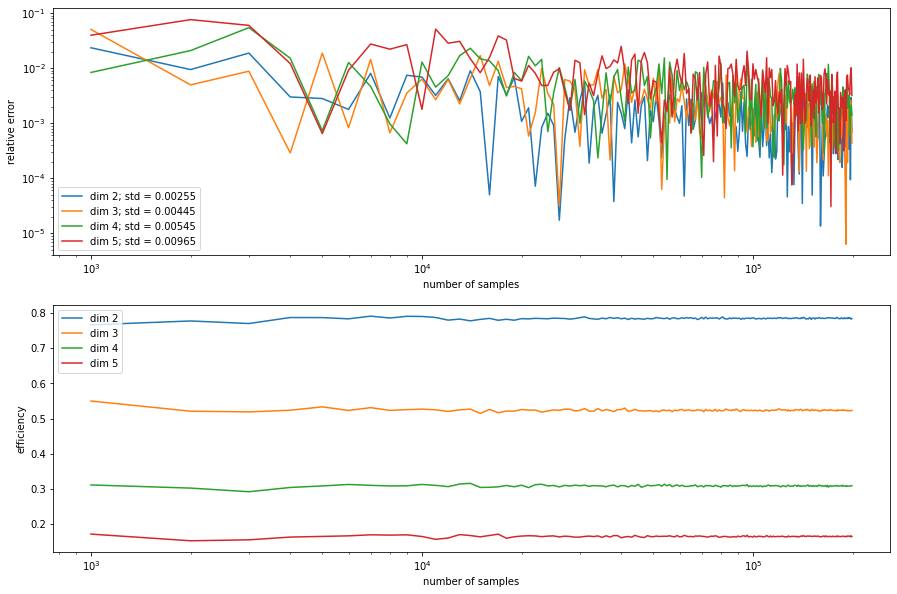

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = 2
volumes = {
    2: np.pi * a,
    3: 4 * np.pi / 3 * a,
    4: np.pi * np.pi / 2 * a,
    5: 8 * np.pi * np.pi / 15 * a
}
N_range = np.arange(1_000, 200_000, 1_000)

def n_dimensional_ellipsoid(dim, N_range=N_range, a=a, volumes=volumes):
    error = []
    efficiency = []
    for N in N_range:
        a_1 = np.random.uniform(-a, a, size=N)
        a_n = np.array([np.random.uniform(-1, 1, size=N) for _ in range(dim-1)])
        hints = len(np.where((a_1 / 2) ** 2 + (a_n ** 2).sum(axis=0) <= 1)[0])
        efficiency += [hints / N]
        error += [np.abs(volumes[dim] - hints / N * (2**(dim-1)) * 2*a) / volumes[dim]]
    return np.array(error), np.array(efficiency)


fig, ax = plt.subplots(2, 1, figsize=(15,10))
for dim in volumes.keys():
    err, eff = n_dimensional_ellipsoid(dim)
    ax[0].plot(N_range, err, label=f"dim {dim}; std = {np.std(err):.{5}f}")
    ax[1].plot(N_range, eff, label=f"dim {dim}")

ax[0].set_xlabel('number of samples')
ax[1].set_xlabel('number of samples')
ax[0].set_ylabel('relative error')
ax[1].set_ylabel('efficiency')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].legend()
plt.show()

## Problem 2

Efficiency of MC with Box-Muller transform is worse than MC with importance sampling. For similar relative errors in IS there is only *1000* samples, while in MB - *2'000'000'0*.

In [2]:
from scipy import stats

h_true = 1 - stats.norm().cdf(4)

# true solution
h_true

3.167124183311998e-05

In [22]:
n_box_muller = 10000000
u1 = np.random.uniform(size=n_box_muller)
u2 = np.random.uniform(size=n_box_muller)
z0 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
z0 = z0[z0>4]
z1 = z1[z1>4]

h_bm = (len(z0) + len(z1)) / (2*n_box_muller)

# mc_bm solution, relative error
h_bm, np.abs(h_true - h_bm) / h_true

(3.2e-05, 0.010380337108733876)

In [24]:
n = 1000
y = stats.expon(loc=4).rvs(n)
h_is = 1.0/n * np.sum(stats.norm().pdf(y)/stats.expon(loc=4).pdf(y))

# mc_is solution, relative error
h_is, np.abs(h_true - h_is) / h_true

(3.2114761703382095e-05, 0.014003867375933097)

## Problem 3

In [79]:
class Target(stats.rv_continuous):
    def _pdf(self, x):
        if x >= 0:
            return 2 * np.exp(-2*x)
        return 0

target = Target()
proposal = stats.norm()
n_steps = 10_000
x = np.zeros(n_steps + 1)
x[0] = 3

for i in range(n_steps):
    x_prime = x[i] + proposal.rvs()
    A = target.pdf(x_prime) / target.pdf(x[i])
    B = proposal.pdf(x[i] - x_prime) / proposal.pdf(x_prime - x[i])
    prob = np.clip(A*B, 0, 1)
    if np.random.rand() < prob:
        x[i+1] = x_prime
    else:
        x[i+1] = x[i]

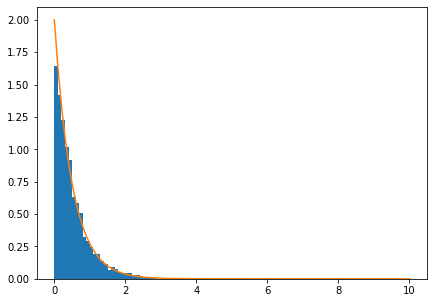

In [90]:
plt.figure(figsize=(7,5))
plt.hist(x, range=[0,10], density=True, bins=100)
xx = np.linspace(0, 10, 100)
plt.plot(xx,2*np.exp(-2*xx));